<a href="https://colab.research.google.com/github/hwanin99/ComputerVision_Seminar/blob/main/%EA%B3%BC%EC%A0%9C/week4_%EA%B3%BC%EC%A0%9C(%EA%B9%80%EC%84%B1%ED%99%98).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pwd

'/content'

In [ ]:
%cd /content/drive/MyDrive/CV_seminar_project

/content/drive/MyDrive/CV_seminar_project


In [ ]:
import torch
import torchvision
from torchvision import transforms # 이미지 데이터 augmentation
import os
import glob

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(42)
if device == 'cuda':
  torch.cuda.manual_seed_all(42)

In [ ]:
device

'cuda'

In [ ]:
root_path = '/content/drive/MyDrive/CV_seminar_project'
train_path = '/content/drive/MyDrive/CV_seminar_project/train'
test_path = '/content/drive/MyDrive/CV_seminar_project/test'

# pytorch 데이터셋 클래스 실습

### 1. 파이토치 데이터 셋 클래스를 직접 만들어보자.

파이토치 데이터 셋 클래스는 init, getitem, len 특수 메소드 3개를 요구한다.   
 항상 같은 포맷을 만드는 습관이 중요하다. 
> 따라서 root_path, mode(train or validation or test), transform(전처리&Augmentation) 3개의 입력을 받아 data와 label을 출력하는 클래스를 만들도록하자.


In [ ]:
from torch.utils.data import Dataset, DataLoader
import cv2
import os 

class Custom_dataset(Dataset):
  def __init__(self, root_path, mode, transforms):
    self.all_data = sorted( glob.glob( os.path.join(root_path, mode, '*', '*') ) ) # 전체 경로
    self.transforms = transforms

  def __getitem__(self, index):
    if torch.is_tensor(index): # 인덱스가 tensor형태일 수 있는 것을 방지
      index = index.tolist()

    data_path = self.all_data[index] # 인덱스가 부여된 데이터 1개
    image = cv2.imread(data_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # cv2 라이브러리의 BGR 형식을 RGB로 permute

    # transfrom 적용
    if self.transforms is not None:
      augmentation = self.transforms(image = image)
      image = augmentation['image']

    # 이미지의 이름을 이용하여, label 부여하기
    if 'dolphin' in data_path:
      label = 0
    elif 'shark' in data_path:
      label = 1
    else:
      label = 2

    return image, label

  def __len__(self):
    length = len(self.all_data)
    return length

### 2. 전처리와 Augmentation을 적용한다.
> Normalize: 픽셀 값에 대해 (X - mean)/std를 진행하며, 이때 통계 값은 ImageNet 데이터 셋의 RGB 통계값을 이용할 것이다.
>   
> 텐서화: 파이토치는 tensor자료 형을 이용하므로 totensor를 해준다.   
>   
> augmentation: trainset에만 적용한다.


In [ ]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2 # albumentations 텐서화 함수

train_transforms = A.Compose([
    A.Resize(224,224),
    A.Transpose(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=20, val_shift_limit=20, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
    A.ChannelShuffle(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0), # 이미지넷 데이터셋 통계값으로 Normalize
    A.CoarseDropout(p=0.5),
    ToTensorV2()
])

test_transforms = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0), # 텐서타입은 안해줌
    ToTensorV2() # Normalize를 먼저하고 tensor화를 진행해야한다.
])

### Pytorch 데이터 클래스 생성
train_class = Custom_dataset(root_path=root_path, mode='train', transforms=train_transforms)
valid_class = Custom_dataset(root_path=root_path, mode='valid', transforms=test_transforms)
test_class = Custom_dataset(root_path=root_path, mode='test', transforms=test_transforms)

### Pytorch BatchLoader 생성 (학습에 이용할 최종 dataloader)
from torch.utils.data import DataLoader as DataLoader

train_loader = DataLoader(train_class, batch_size=8, shuffle = True, num_workers=0)
valid_loader = DataLoader(valid_class, batch_size=8, shuffle = False, num_workers=0)
test_loader = DataLoader(test_class, batch_size=8, shuffle = False, num_workers=0)

# week4 과제
아래와 같이 원래 0~255 픽셀 값을 가진 귀여운 돌고래 이미지는 Augmentation이 적용되어(train_class[0][0]) 이미지가 변형 되었다.   
**train_class[0][0] 데이터**를 시각화 할 수 있도록 시각화 라이브러리가 요구하는 numpy 타입의 올바른 이미지 데이터로 되돌리는 역함수를 만들어 시각화 해오는 것.   

결과물에 대해서는 week4 pdf의 과제 설명에 있는 이미지를 보시면 이해될 것입니다.

In [ ]:
train_class.all_data[0]

'/content/drive/MyDrive/CV_seminar_project/train/dolphin/dolphin_000.jpg'

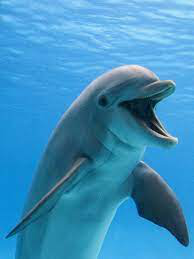

In [ ]:
from PIL import Image as PILImage
PILImage.open(train_class.all_data[0])

In [ ]:
train_class[0][0] # 역함수를 이용해 이것을 시각화 해주세요.

tensor([[[-0.6452, -0.6452, -0.6281,  ..., -1.1589, -1.2103, -1.2617],
         [-0.6794, -0.6109, -0.6109,  ..., -1.2788, -1.2788, -1.2788],
         [-0.6109, -0.6109, -0.6109,  ..., -1.2788, -1.2617, -1.2445],
         ...,
         [-1.6042, -1.6042, -1.6042,  ..., -1.6727, -1.6384, -1.6384],
         [-1.6042, -1.6042, -1.6042,  ..., -1.6727, -1.6727, -1.6384],
         [-1.6042, -1.6042, -1.6042,  ..., -1.6727, -1.6727, -1.6384]],

        [[ 2.2885,  2.2535,  2.2710,  ...,  2.2535,  2.2010,  2.1485],
         [ 2.2710,  2.3060,  2.3235,  ...,  2.1310,  2.1485,  2.1660],
         [ 2.3060,  2.3060,  2.3060,  ...,  2.1485,  2.1835,  2.2010],
         ...,
         [ 2.0784,  2.0784,  2.0784,  ...,  1.0630,  1.0805,  1.0980],
         [ 2.0784,  2.0784,  2.0784,  ...,  1.0630,  1.0630,  1.0805],
         [ 2.0609,  2.0784,  2.0784,  ...,  1.0630,  1.0630,  1.0805]],

        [[ 1.8557,  1.8034,  1.8208,  ...,  1.6988,  1.6465,  1.5942],
         [ 1.8208,  1.8731,  1.8905,  ...,  1

#과제

## 원래 이미지 출력
*transforms=None인 train_class2를 생성

In [ ]:
train_class2=Custom_dataset(root_path=root_path, mode='train', transforms=None)
train_class2[0][0]

array([[[ 76, 158, 205],
        [ 84, 166, 213],
        [ 92, 174, 221],
        ...,
        [162, 214, 235],
        [172, 222, 245],
        [172, 222, 247]],

       [[ 91, 173, 221],
        [ 98, 182, 228],
        [108, 190, 238],
        ...,
        [170, 222, 244],
        [165, 217, 241],
        [165, 216, 243]],

       [[ 96, 179, 229],
        [102, 188, 235],
        [113, 196, 246],
        ...,
        [175, 229, 253],
        [164, 218, 246],
        [164, 217, 248]],

       ...,

       [[ 47, 164, 231],
        [ 47, 164, 231],
        [ 45, 164, 230],
        ...,
        [ 68, 174, 232],
        [ 69, 172, 230],
        [ 69, 173, 228]],

       [[ 49, 164, 231],
        [ 47, 164, 231],
        [ 46, 163, 230],
        ...,
        [ 69, 174, 231],
        [ 71, 171, 230],
        [ 71, 172, 228]],

       [[ 49, 164, 231],
        [ 47, 164, 231],
        [ 46, 163, 230],
        ...,
        [ 69, 174, 231],
        [ 71, 171, 230],
        [ 71, 172, 228]]

###PIL

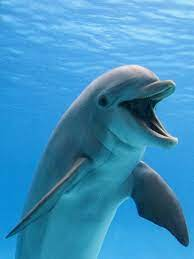

In [ ]:
from PIL import Image as PILImage
none_img=transforms.ToPILImage()
original_img=none_img(train_class2[0][0])
original_img

###cv2_imshow

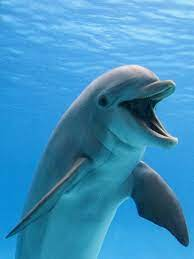

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(cv2.cvtColor(train_class2[0][0], cv2.COLOR_BGR2RGB))

## tensor를 numpy 형태로 변환
* 위의 train_class[0][0]을 시각화

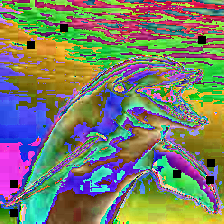

In [ ]:
trans_img=transforms.ToPILImage()
augmentationed_img=trans_img(train_class[0][0])
augmentationed_img

## train_class가 총 917개이므로, 1~1000까지 랜덤하게 숫자를 뽑아서 시각화하기

2


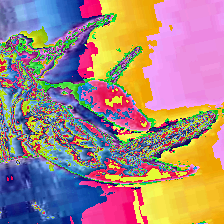

In [ ]:
import random
def converter(augmentationed_image):
  i=random.randrange(1,1000)
  t=transforms.ToPILImage()
  converted_image=t(augmentationed_image[i][0])
  return converted_image
  
converter(train_class)

## 시각화

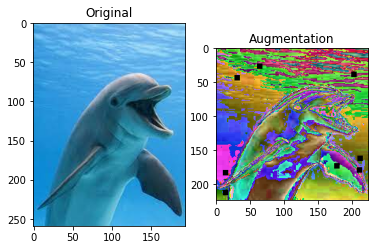

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))

plt.subplot(121,title='Original')
plt.imshow(original_img)
plt.subplot(122,title='Augmentation')
plt.imshow(augmentationed_img)

## 수정한 과제

* train_class 채널축 변경
* 픽셀값을 0~255값으로 변경
* numpy형태로 변경
* ndarray -> float으로 바꿔서 plt.imshow()로 시각화

In [ ]:
import numpy as np
from google.colab.patches import cv2_imshow
ndarray_aug_img2=np.array(train_class[0][0].permute(1,2,0)*255)
augmentationed_img2=ndarray_aug_img2.astype(int)

In [ ]:
ndarray_aug_img2

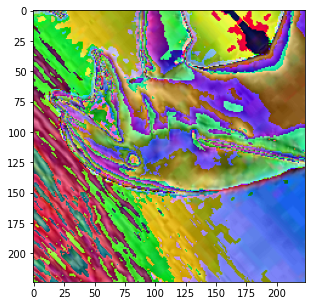

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(augmentationed_img2)

* Normalize -> (X - mean)/std, Unnomarize -> (X*std) + Mean -> 픽셀값 : 0 ~ 1 -> 0 ~ 255

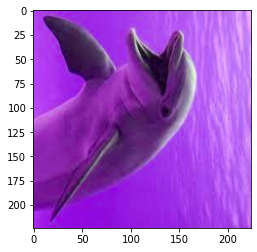

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
image = train_class[0][0].permute(1, 2, 0).numpy()
# unnormalize
mean=(0.485, 0.456, 0.406)
std=(0.229, 0.224, 0.225)

augmentation_img=(((image * std)+mean)*255).astype(int)
plt.imshow(augmentation_img)

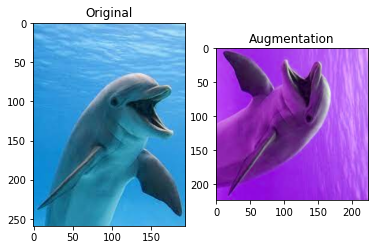

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))

plt.subplot(121,title='Original')
plt.imshow(original_img)
plt.subplot(122,title='Augmentation')
plt.imshow(augmentation_img)

* 역함수 로직

In [ ]:
def converter(augmentationed_image):
  mean=(0.485, 0.456, 0.406)
  std=(0.229, 0.224, 0.225)
  
  ### 역함수 로직을 짜주세요. ###
  augmentationed_image = augmentationed_image.permute(1,2,0) # 채널축 정상적으로 맨뒤로 보내기
  augmentationed_image = augmentationed_image.numpy() # numpy 타입으로 변환
  augmentationed_image = (augmentationed_image * std) + mean # unnormalize
  converted_image = augmentationed_image * 255
  converted_image = converted_image.astype(int)

  return converted_image